In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.30.1

numpy       : 1.21.2
pandas      : 1.3.4
torch       : 1.7.1
transformers: 4.16.0.dev0



In [2]:
import transformers
from transformers import BertModel, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# , BertweetTokenizer, BertweetModel
from transformers import AutoModel, AutoTokenizer
import torch

from datetime import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=1)

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
EMOTION = 'sentiment'
MAX_LEN = 350
CLASS_NAMES = ['negative', 'positive']

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, use_fast=False)

In [5]:
df1 = pd.read_json('review.jl', lines=True)
df2 = pd.read_json('products.jl', lines=True)
df1

,product_id,page,page_order,recommended,date,text,hours,user_id,username,products,early_access,compensation,found_funny
0,1644960,1,0,False,11 January,this game is ♥♥♥♥ if u dont have ur moms credi...,105.8,7.656120e+16,ajay,8.0,False,NaN,NaN
1,1644960,1,1,True,11 January,Was happy with NBA2K21 but somehow I felt the ...,7.8,NaN,Taleweaver,146.0,False,NaN,NaN
2,1644960,1,2,True,11 January,"Its honestly an amazing game, very fun to buil...",141.5,7.656120e+16,rileyfriedrich07,3.0,False,NaN,NaN
3,1644960,1,3,False,10 January,"This game is garbage. Pure hot garbage, Server...",89.4,7.656120e+16,Your favorite dickhead,134.0,False,NaN,NaN
4,1644960,1,4,False,10 January,"I cant stand this game anymore, I really tried...",141.4,7.656120e+16,Hex:DevourBooty,51.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,285190,83,3,True,2020-11-26,this game is great,21.6,7.656120e+16,Rodney Gallowglass,516.0,False,NaN,1.0
47996,285190,83,4,False,2020-11-26,If you are a warhammer fan go for soulstorm or...,12.1,7.656120e+16,m.galal,30.0,False,NaN,3.0
47997,285190,83,5,True,2020-11-26,I wish the 40k community hadn't killed this ga...,16.1,7.656120e+16,LENOVA,137.0,False,NaN,2.0
47998,285190,83,6,True,2020-11-26,I would recommend this game.\nDespite the hone...,26.9,7.656120e+16,BrotherZane,74.0,False,NaN,NaN


In [6]:
df1 = pd.read_json('review.jl', lines=True)
df1 = df1[['product_id', 'recommended', 'text']]
df1 = df1.dropna()


In [7]:
normal_df = df1[df1['recommended'] == 0]
class_df = df1[df1['recommended'] == 1]

In [8]:
label = np.ones(len(class_df), dtype = int)
class_df.insert(1, 'label', label)


label = np.zeros(len(normal_df), dtype = int)
normal_df.insert(1, 'label', label)

In [9]:
class_df, _ = train_test_split(class_df, train_size = 0.56)
df = pd.concat([class_df, normal_df], ignore_index=True)
print("Number of negative samples:", len(df[df['label'] == 0]))
print("Number of positive samples:", len(df[df['label'] == 1]))
df

Number of negative samples: 17494
Number of positive samples: 17083


,product_id,label,recommended,text
0,1225330,1,True,yes
1,340170,1,True,GOOD
2,1225330,1,True,Awesome
3,1015500,1,True,"Good but never like ""here comes the pain"" in t..."
4,674020,1,True,very good game
...,...,...,...,...
34572,1402320,0,False,I was downright giddy to play a VR game by my ...
34573,1402320,0,False,"Gun play is Janky As F_ck,\n1: So Grenades are..."
34574,1402320,0,False,After day 1 I returned. Not optimized and alm...
34575,285190,0,False,If you are a warhammer fan go for soulstorm or...


In [10]:
class SentimentDataset(Dataset):
    def __init__(self, sentences, targets, tokenizer, max_len):
        self.sentences = sentences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(), ## look up this function,
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype = torch.long)
        }

In [11]:
df_train, df_test = train_test_split(df, train_size = 0.8)
df_test, df_val = train_test_split(df_test, train_size = 0.5)
print(df_train.shape, df_val.shape, df_test.shape)


(27661, 4) (3458, 4) (3458, 4)


In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        sentences = df['text'].to_numpy(),
        targets = df['label'].to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )
    
    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 4
    )

In [13]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids = input_ids, 
            attention_mask = attention_mask
        ).pooler_output
        # print(pooled_output)
        output = self.drop(pooled_output)
        return self.out(output)


In [15]:
model = SentimentClassifier(len(CLASS_NAMES))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# Training
EPOCHS = 6
LEARNING_RATE = 5e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    
    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    print(f"[Training] Correct predictions: {correct_predictions.double()}, Total examples: {n_examples}")
    return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    
    print(f"[Validation] Correct predictions: {correct_predictions.double()}, Total examples: {n_examples}")
    return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
%%time
def save_model(best_accuracy, best_state_dict):
    global filename
    acc_string = "{:.2f}".format(best_accuracy)
    filename = f"{EMOTION}-{dt.now().strftime('%Y-%m-%d-%H-%M-%S')}-{acc_string}.pkl"
    torch.save(best_state_dict, filename)

filename = ""

history = defaultdict(list)

best_accuracy = 0.0
best_state_dict = {}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'[Training] Loss: {train_loss} Accuracy: {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'[Validation] Loss: {val_loss} Accuracy: {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_state_dict = model.state_dict()

save_model(best_accuracy, best_state_dict)

Epoch 1/6
----------
[Training] Correct predictions: 23885.0, Total examples: 27661
[Training] Loss: 0.3436788499420358 Accuracy: 0.8634901124326669
[Validation] Correct predictions: 3065.0, Total examples: 3458
[Validation] Loss: 0.3280422741694561 Accuracy: 0.8863504916136494

Epoch 2/6
----------
[Training] Correct predictions: 25474.0, Total examples: 27661
[Training] Loss: 0.257443672964494 Accuracy: 0.9209356133183905
[Validation] Correct predictions: 3085.0, Total examples: 3458
[Validation] Loss: 0.41095516809335464 Accuracy: 0.8921341816078657

Epoch 3/6
----------
[Training] Correct predictions: 26076.0, Total examples: 27661
[Training] Loss: 0.21359341153902936 Accuracy: 0.9426991070460214
[Validation] Correct predictions: 3077.0, Total examples: 3458
[Validation] Loss: 0.5010098657690017 Accuracy: 0.8898207056101792

Epoch 4/6
----------
[Training] Correct predictions: 26515.0, Total examples: 27661
[Training] Loss: 0.16582989162639736 Accuracy: 0.9585698275550414
[Validati

In [20]:
filename

'sentiment-2022-01-13-03-19-39-0.89.pkl'

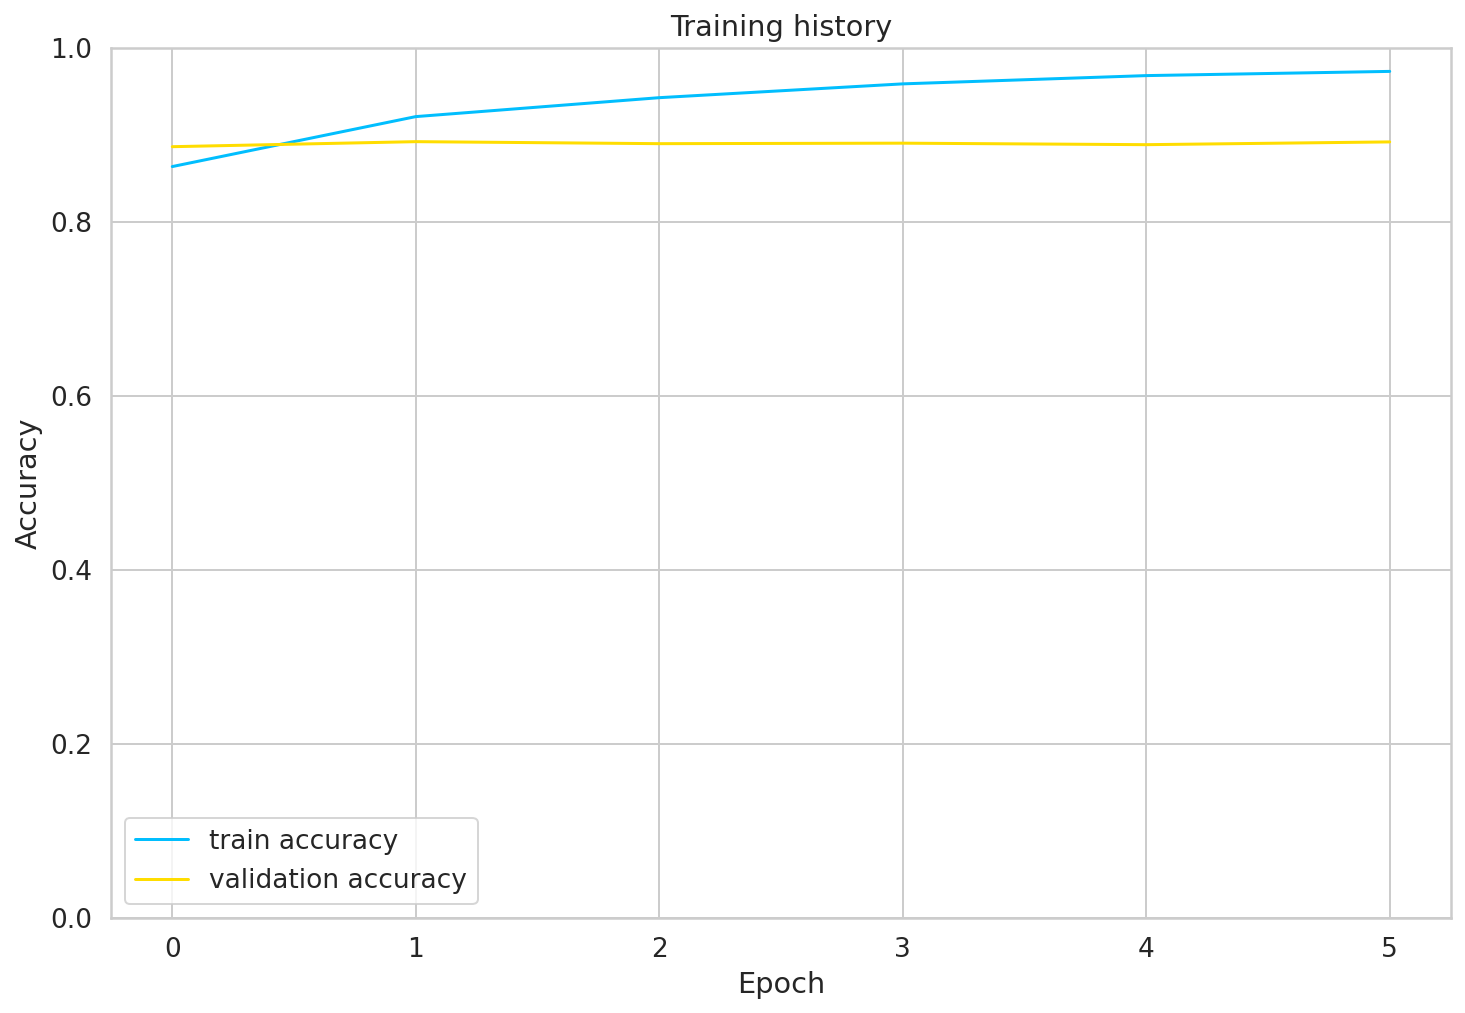

In [21]:
train_acc = [_.cpu() for _ in history['train_acc']]
plt.plot(train_acc, label='train accuracy')

val_acc = [_.cpu() for _ in history['val_acc']]
plt.plot(val_acc, label='validation accuracy')


plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [22]:
model.load_state_dict(torch.load(filename))
model.eval()

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

[Validation] Correct predictions: 3128.0, Total examples: 3458


0.9045691150954308

In [23]:
def get_predictions(model, data_loader):
    model = model.eval()
    sentences = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            sentence = d["sentence"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            sentences.extend(sentence)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return sentences, predictions, prediction_probs, real_values

In [24]:
y_sentences, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [25]:
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    negative       0.90      0.91      0.90      1704
    positive       0.91      0.90      0.91      1754

    accuracy                           0.90      3458
   macro avg       0.90      0.90      0.90      3458
weighted avg       0.90      0.90      0.90      3458



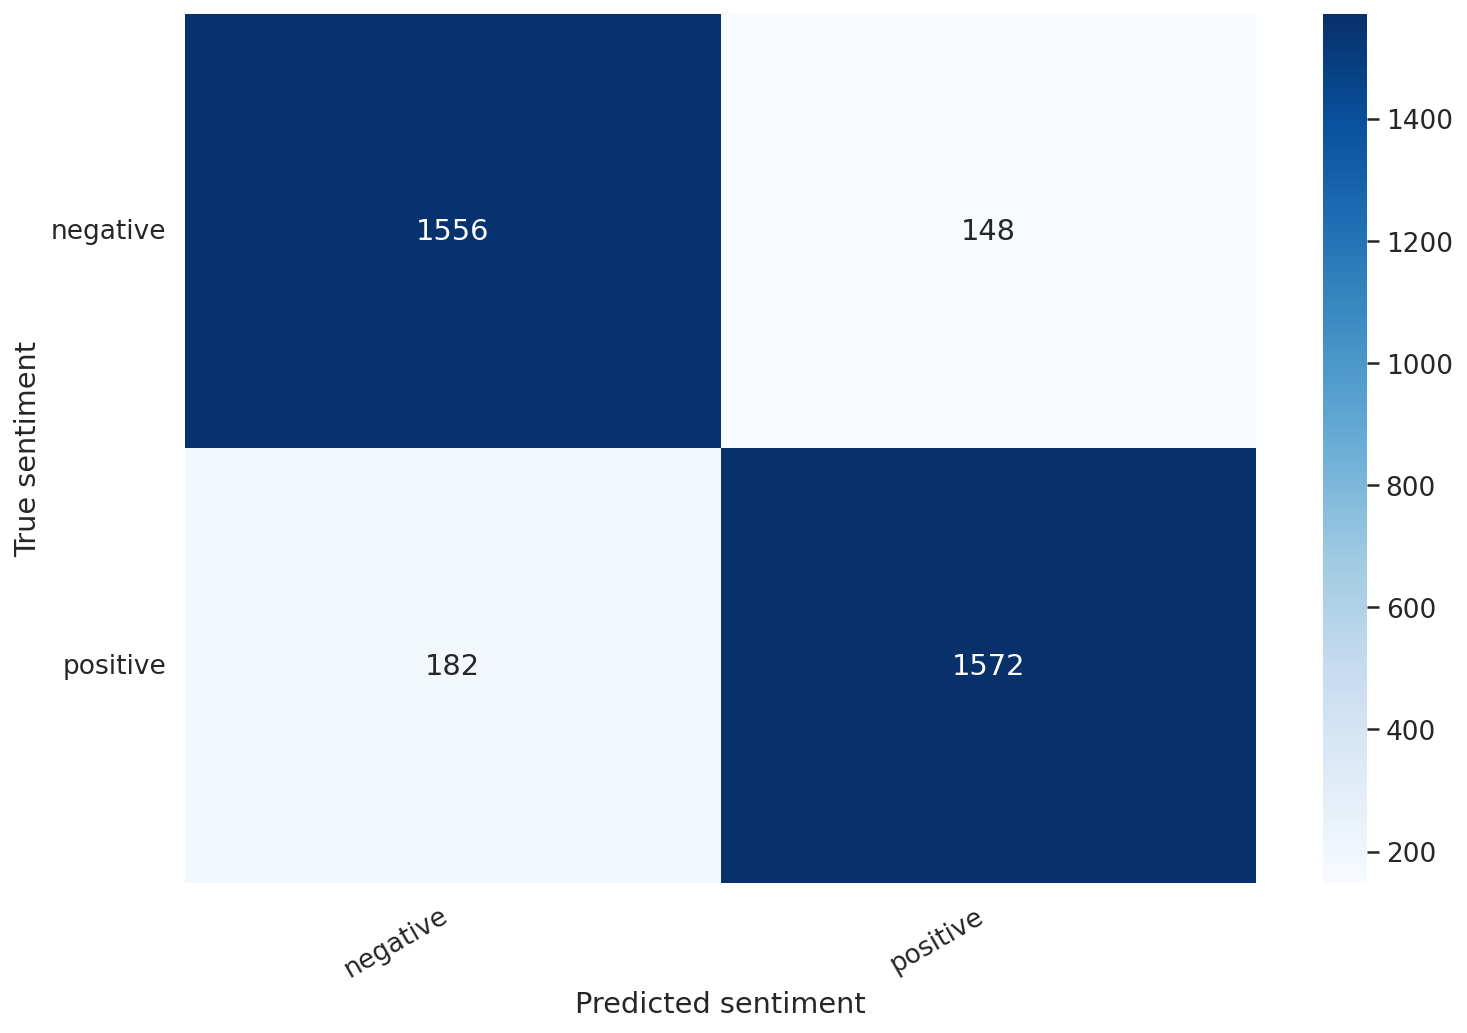

In [26]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)